In [1]:
import numpy as np
from collections import defaultdict

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline
plt.rcParams['figure.dpi'] = 200

# Create connectivity matrices

First we must create the connectivity matrix between neurons. 
In the following cell, we make a fully-connected network using the following steps:
1. Create a uniformly random 1000x1000 matrix 
2. Define 20% of the neurons to be inhibitory.
3. Change all connections for inhibitory neurons multiplying by -1. 
4. Let average connection be 1/n_neurons by dividing all weights. 
5. Remove self-connections

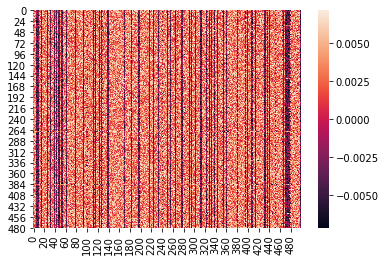

In [312]:
N_NEURONS = 500
def get_W_matrix():
    W = np.random.rand(N_NEURONS, N_NEURONS) # Step 1

    random_inhib = (np.random.rand(N_NEURONS) <.2) # Step 2
    W[:, random_inhib] = -1* W[:, random_inhib] # Step 3

    # Step 4
    ratio = 1 / N_NEURONS / W.mean()
    W = ratio * W 

    # Step 5
    for i in range(N_NEURONS):
        W[i,i] = 0
        
    return W

W = get_W_matrix()
sns.heatmap(W)

In [313]:
# Thalamic connections weights
omega = np.ones((N_NEURONS, 1)) * 8 / N_NEURONS

# Main Network object

In [314]:
def sigmoid(x, x0, k):
    return 1. / (1. + np.exp(-k*(x -x0)))

class Network(object):
    def __init__(self, 
                 v0, 
                 W, 
                 omega,
                 history_variables=['v', 's']):
        
        """
        Parameters
        ----------
        
        history_variables: list of string
            Be careful with saving a lot of things.
            It may break RAM (especially saving W)
        """
        self.v = v0
        self.s = np.zeros_like(v0)
        
        self.W0 = W.copy()
        self.W = W
        self.omega0 = omega.copy()
        self.omega = omega 
        self.r = None   
        self.s_thalamus = None  # Thalamic spikes
        
        self.tau_r = 400 # Recovery rate for short term depression
        self.tau_d = 20  # Decay rate for short term depression
        self.leakage = .2 # Equals 1 / membrane time constant tau m
        
        self.history_variables = history_variables
        self.history = defaultdict(lambda: [])
        
        
    def spike(self, v, threshold=1):
        s = (v >= np.random.rand(*v.shape)) # Probabilistic spike
        v[s] = 0
        return s, v

    def propagate_spike(self, s):
        nt = self.W @ s
        return nt # Neurotransmitters

    def synapse(self, nt):
        dv = .3 * nt # Delta voltage
        return dv

    def external_input(self):
        self.s_thalamus = (np.random.rand(*self.v.shape) < self.r)
        return self.s_thalamus*omega
    
    def plasticity(self):
        """
        There are two components in each update (equal for both W and omega)
            The recovery component, "homeostatic" (1/self.tau_r) * (self.W0 - self.W)
            The decay component, only when spikes occur (1/self.tau_d) * self.W * self.s 
        """
        self.W = self.W  + (1/self.tau_r) * (self.W0 - self.W) - (1/self.tau_d) * self.W * self.s
        self.omega = self.omega  + (1/self.tau_r) * (self.omega0 - self.omega) - (1/self.tau_d) * self.omega * self.s_thalamus

    def run_simulation(self, r, tmax):
        """
        Parameters
        ----------
        
        r: float, between 0 and 1
            Strenght of talamic input (initialized in simulation)
            It defines the probability that a given thalamic neuron will fire
            
        tmax : integer
            Number of iterations to run the network
        """
        self.r = r
        for t_i in range(tmax):
            self.s, v = self.spike(self.v)
            nt        = self.propagate_spike(self.s)
            ei        = self.external_input()
            dv        = self.synapse(nt) + ei
            self.v    = v + dv - v * self.leakage
            
            self.append_history()
            self.plasticity()

    def append_history(self):
        for var in self.history_variables:
            self.history[var].append(getattr(self, var))
            
    def get_history(self, attr):
        return np.hstack(self.history[attr])
    
    def run_schedule(self, stim_durations, stim_strenghts):
        assert len(stim_durations) == len(stim_strenghts), "Should be same size"
        for tmax, r in zip(stim_durations, stim_strenghts):
            self.run_simulation(r, tmax)

# Run the Network

In [306]:
!mkdir data

mkdir: data: File exists


## Simulate and store 

In [308]:
import pickle
from tqdm.notebook import tqdm

for i in tqdm(range(1)): # ex. range(3, 30)
    net = Network(v0=np.zeros((N_NEURONS,1)), 
              W=get_W_matrix(),
              omega=omega, 
              history_variables=['s'])

    # Low stim intensity   
#     net.run_schedule(stim_durations = [   100,   100,   100,  100, 5000], 
#                      stim_strenghts = [.00005, .0001, .0005, .001,  .01]) # 0.1 0.2
    
    # High stim intensity
    net.run_schedule(stim_durations = [   100,   100,  100,  200, 5000], 
                     stim_strenghts = [.00005, .0005, .005, 0.01,  .05])
    
    
    filepath = f'data/spikes_{i}.pkl'
    spikes_i = net.get_history('s')
    pickle.dump(spikes_i, open(filepath, 'wb'))

In [309]:
# plt.figure(dpi=200)
# sns.heatmap(net.get_history('v')[:, :1000])
# plt.title("Voltage across time for all neurons");

In [310]:
import ipywidgets as wdg

spikes_i = pickle.load(open('data/spikes_0.pkl', 'rb'))

def rasterplot(spike_history, dt=1, t0=0, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    n, t = np.nonzero(spike_history)
    ax.scatter(t, n, color='k', **kwargs)
    ax.set_yticks([])
    ax.set_xlim(0, spike_history.shape[1])
    
    xticks = ax.get_xticks()
    ax.set_xticklabels((xticks*dt + t0).astype(int))
    return ax

def plot_raster(trange):
    plt.figure(dpi=200)
    rasterplot(spikes_i[:, trange[0]:trange[1]], 1, t0=trange[0], s=0.01)
    sns.despine(left=True)
    plt.title("Spike rasterplot")


wdg.interact_manual(plot_raster, trange = wdg.IntRangeSlider(value=(0,6000),
                                                             min=0, 
                                                             max=6000));

interactive(children=(IntRangeSlider(value=(0, 6000), description='trange', max=6000), Button(description='Run…

In [311]:
import ipywidgets as wdg

def plot_avg_spk(trange):
    pd.Series(spikes_i.sum(axis=0))[trange[0]:trange[1]].plot()
    pd.Series(spikes_i.sum(axis=0)).rolling(100).mean(center=True)[trange[0]:trange[1]].plot()
    plt.title("Average firing rate across population")
    
wdg.interact_manual(plot_avg_spk, trange = wdg.IntRangeSlider(value= (0,6000),
                                                             min=0, 
                                                             max=6000));

interactive(children=(IntRangeSlider(value=(0, 6000), description='trange', max=6000), Button(description='Run…

# Define avalanches

In [302]:
def avalanche_stats(spike_matrix):
    """
    Example
    -------
    avalanche_sizes, avalanche_durations = avalanche_stats(spike_matrix)
    """
    total_spikes = spike_matrix.sum(axis=0)
    total_spikes = np.hstack(([0], total_spikes)) # Assure it starts with no spike
    avalanche = pd.Series(total_spikes >= 1)
    
    event = (avalanche.astype(int).diff().fillna(0)!=0)
    event_indexes = event.to_numpy().nonzero()[0]

    if len(event_indexes) % 2 == 0:
        avalanche_periods = event_indexes.reshape(-1,2)
    else:
        avalanche_periods = event_indexes[:-1].reshape(-1,2)
        
    avalanche_durations = avalanche_periods[:, 1] - avalanche_periods[:, 0]

    avalanche_sizes = np.array([total_spikes[avalanche_periods[i][0]: avalanche_periods[i][1]].sum()
                        for i in range(len(avalanche_periods))])
    
    total_avalanches = len(event_indexes)
    
    return total_avalanches, avalanche_sizes, avalanche_durations

# Compute avalanche sizes and durations

In [303]:
transient_state = {
    'total': [],
    'durations': [],
    'sizes': []}
steady_state = {
    'total': [],
    'durations': [],
    'sizes': []}

for i in tqdm(range(1)):
    filepath = f'data/spikes_{i}.pkl'
    spikes_i = pickle.load(open(filepath, 'rb')) 
    
    transient_times = np.array([0]*500 + [1]*1000 + [0]*4000)==1
    
    # Transient 
    total_avalanches, avalanche_sizes, avalanche_durations = avalanche_stats(spikes_i[:, transient_times==True])
    transient_state['total'] += [total_avalanches]
    transient_state['durations'] += list(avalanche_durations)
    transient_state['sizes'] += list(avalanche_sizes)
    # Steady 
    total_avalanches, avalanche_sizes, avalanche_durations = avalanche_stats(spikes_i[:, transient_times==False])
    steady_state['total'] += [total_avalanches]
    steady_state['durations'] += list(avalanche_durations)
    steady_state['sizes'] += list(avalanche_sizes)
    
print(transient_state['total'])
print(steady_state['total'])


[31]
[51]


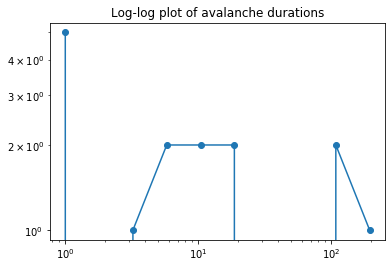

In [304]:
density, bin = np.histogram(np.log10(transient_state['durations']), density=False, bins=10)
durations = 10**bin[:-1]

plt.plot(durations, density, marker='o')
plt.yscale('log')
plt.xscale('log')
plt.title("Log-log plot of avalanche durations");

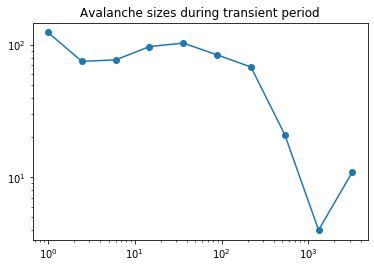

In [241]:
density, bin = np.histogram(np.log10(transient_state['sizes']), density=False)
sizes = 10**bin[:-1]

plt.plot(sizes, density, marker='o')
plt.yscale('log')
plt.xscale('log')
plt.title('Avalanche sizes during transient period');

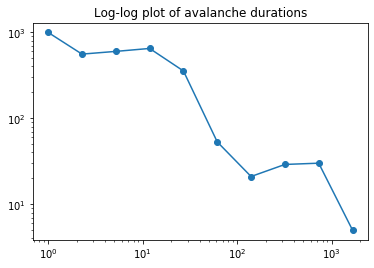

In [242]:
density, bin = np.histogram(np.log10(steady_state['durations']), density=False, bins=10)
durations = 10**bin[:-1]

plt.plot(durations, density, marker='o')
plt.yscale('log')
plt.xscale('log')
plt.title("Log-log plot of avalanche durations");

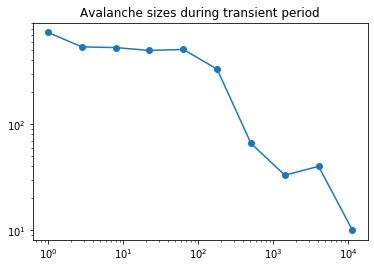

In [243]:
density, bin = np.histogram(np.log10(steady_state['sizes']), density=False)
sizes = 10**bin[:-1]

plt.plot(sizes, density, marker='o')
plt.yscale('log')
plt.xscale('log')
plt.title('Avalanche sizes during transient period');

In [244]:
import powerlaw

transient_durations = powerlaw.Fit(transient_state['durations'])
print(transient_durations.power_law.alpha)
print(transient_durations.power_law.xmin)

transient_sizes = powerlaw.Fit(transient_state['sizes'])
print(transient_sizes.power_law.alpha)
print(transient_sizes.power_law.xmin)

transient_state['durations'] = powerlaw.trim_to_range(transient_state['durations'], xmin = transient_durations.power_law.xmin, xmax = None)
transient_state['sizes'] = powerlaw.trim_to_range(transient_state['sizes'], xmin = transient_sizes.power_law.xmin, xmax = None)

# Returns the optimal xmin beyond which the scaling regime of the power law fits best. 
# The optimal xmin beyond which the scaling regime of the power law fits best is identified 
# by minimizing the Kolmogorov-Smirnov distance between the data and the theoretical power law fit.

2.199611086687815
15.0
2.0492764480708905
166.0


Calculating best minimal value for power law fit
/Users/gabimelo/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


In [245]:
steady_durations = powerlaw.Fit(steady_state['durations'])
print(steady_durations.power_law.alpha)
print(steady_durations.power_law.xmin)

steady_sizes = powerlaw.Fit(steady_state['sizes'])
print(steady_sizes.power_law.alpha)
print(steady_sizes.power_law.xmin)

steady_state['durations'] = powerlaw.trim_to_range(steady_state['durations'], xmin = steady_durations.power_law.xmin, xmax = None)
steady_state['sizes'] = powerlaw.trim_to_range(steady_state['sizes'], xmin = steady_sizes.power_law.xmin, xmax = None)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


2.097553853967735
13.0
1.8874314044940146
100.0


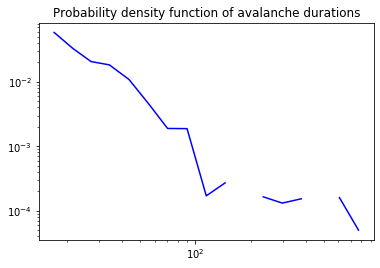

In [246]:
powerlaw.plot_pdf(transient_state['durations'], color='b')
plt.title("Probability density function of avalanche durations");

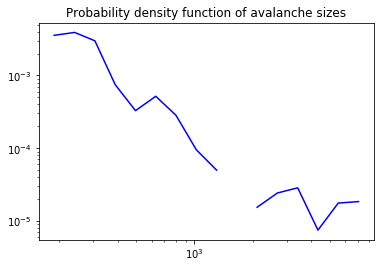

In [247]:
powerlaw.plot_pdf(transient_state['sizes'], color='b')
plt.title("Probability density function of avalanche sizes");

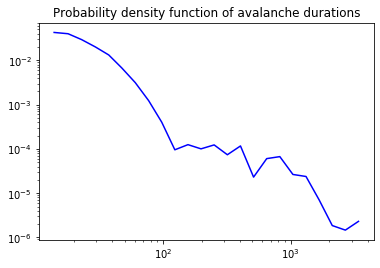

In [248]:
powerlaw.plot_pdf(steady_state['durations'], color='b')
plt.title("Probability density function of avalanche durations");

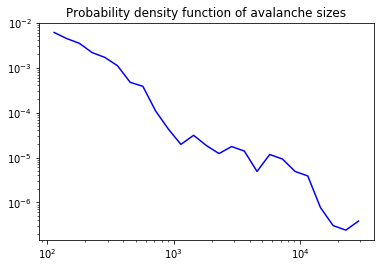

In [249]:
powerlaw.plot_pdf(steady_state['sizes'], color='b')
plt.title("Probability density function of avalanche sizes");

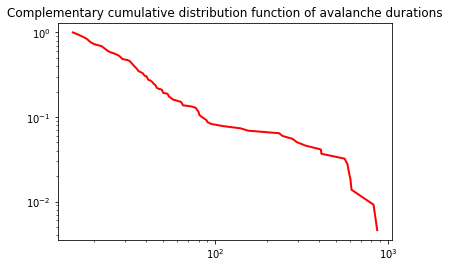

In [250]:
transient_durations.plot_ccdf(color='r', linewidth=2)
plt.title("Complementary cumulative distribution function of avalanche durations");

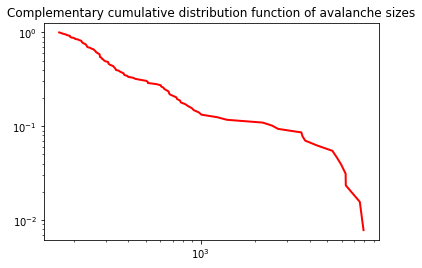

In [251]:
transient_sizes.plot_ccdf(color='r', linewidth=2)
plt.title("Complementary cumulative distribution function of avalanche sizes");

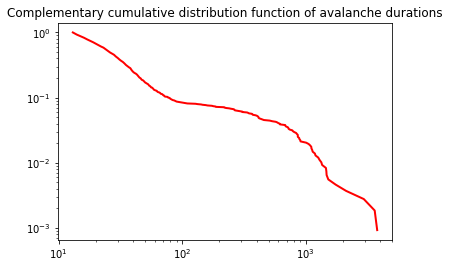

In [252]:
steady_durations.plot_ccdf(color='r', linewidth=2)
plt.title("Complementary cumulative distribution function of avalanche durations");

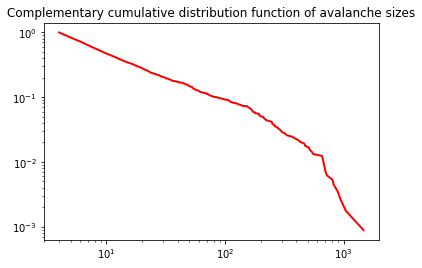

In [211]:
steady_sizes.plot_ccdf(color='r', linewidth=2)
plt.title("Complementary cumulative distribution function of avalanche sizes");

lognormal_positive 304.40687777688186 6.024699715549465e-76
lognormal 0.5215286842870701 3.09384940150664e-35


/Users/gabimelo/anaconda3/lib/python3.7/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


truncated_power_law 2.8433319911203014e-05 0.9939832117312176


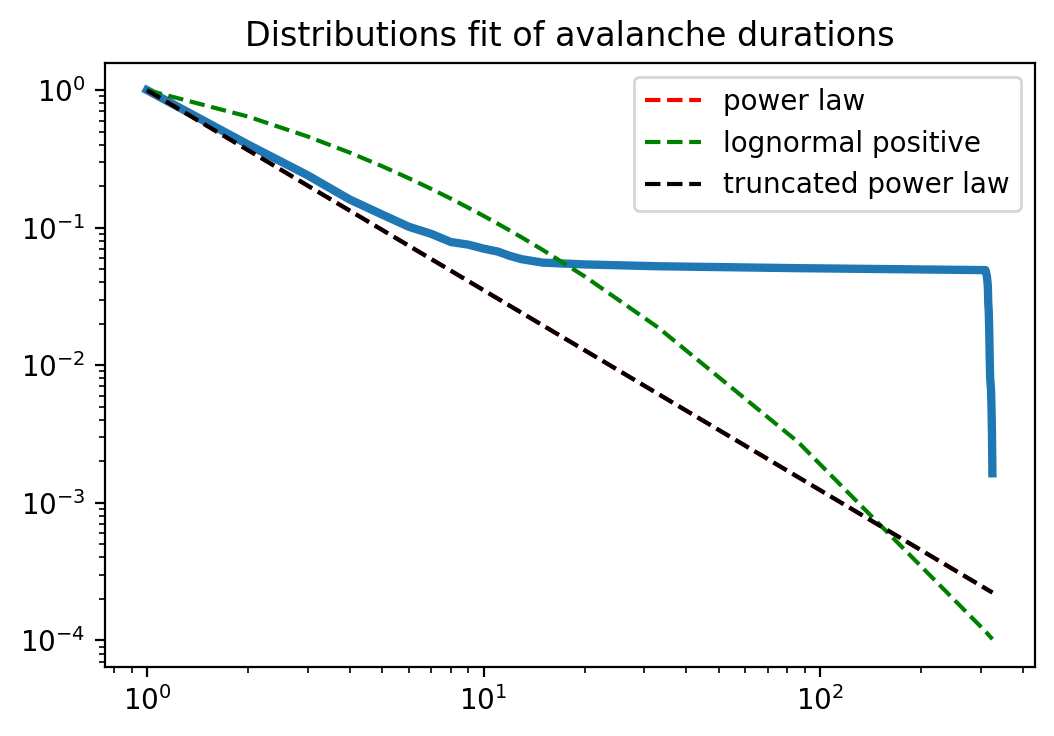

In [212]:
# Returns the loglikelihood ratio, and its p-value, between the two distribution fits.

for distribution in ['lognormal_positive', 
                     'lognormal', 'truncated_power_law']:
    R, p = transient_durations.distribution_compare('power_law', distribution)
    print(distribution, R, p)
    
plt.subplots(dpi=200)
fig4=transient_durations.plot_ccdf(linewidth=3)
transient_durations.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--', label = 'power law')
transient_durations.lognormal_positive.plot_ccdf(ax=fig4, color='g', linestyle='--', label = 'lognormal positive')
transient_durations.truncated_power_law.plot_ccdf(ax=fig4, color='k', linestyle='--', label = 'truncated power law')
plt.legend()
plt.title('Distributions fit of avalanche durations');

lognormal_positive 330.6130215773764 1.0010979124564293e-102
lognormal -19.225634008026983 1.4287493504711292e-07


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


truncated_power_law 8.649918874885365e-07 0.9989505519346225


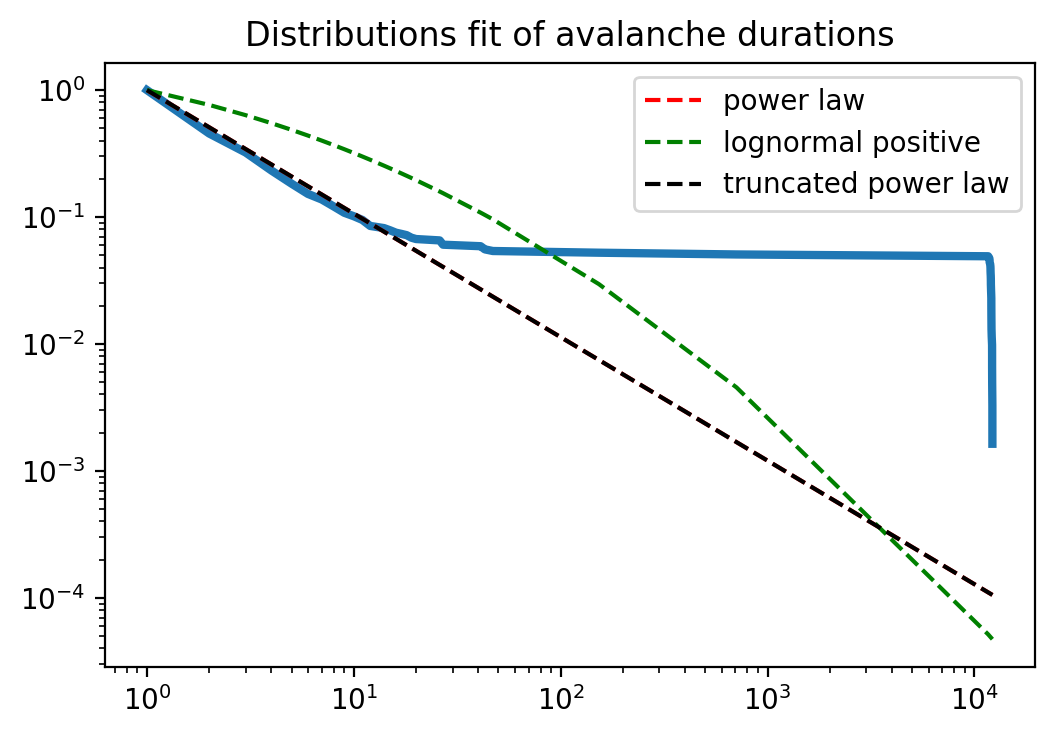

In [213]:
for distribution in ['lognormal_positive', 
                     'lognormal', 'truncated_power_law']:
    R, p = transient_sizes.distribution_compare('power_law', distribution)
    print(distribution, R, p)
    
plt.subplots(dpi=200)
fig4=transient_sizes.plot_ccdf(linewidth=3)
transient_sizes.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--', label = 'power law')
transient_sizes.lognormal_positive.plot_ccdf(ax=fig4, color='g', linestyle='--', label = 'lognormal positive')
transient_sizes.truncated_power_law.plot_ccdf(ax=fig4, color='k', linestyle='--', label = 'truncated power law')
plt.legend()
plt.title('Distributions fit of avalanche durations');

lognormal_positive 9.559769163724425 0.024916604133338006
lognormal -0.23547058990806136 0.6411639285288357
truncated_power_law -3.713002890858225 0.006428788143475694


Assuming nested distributions


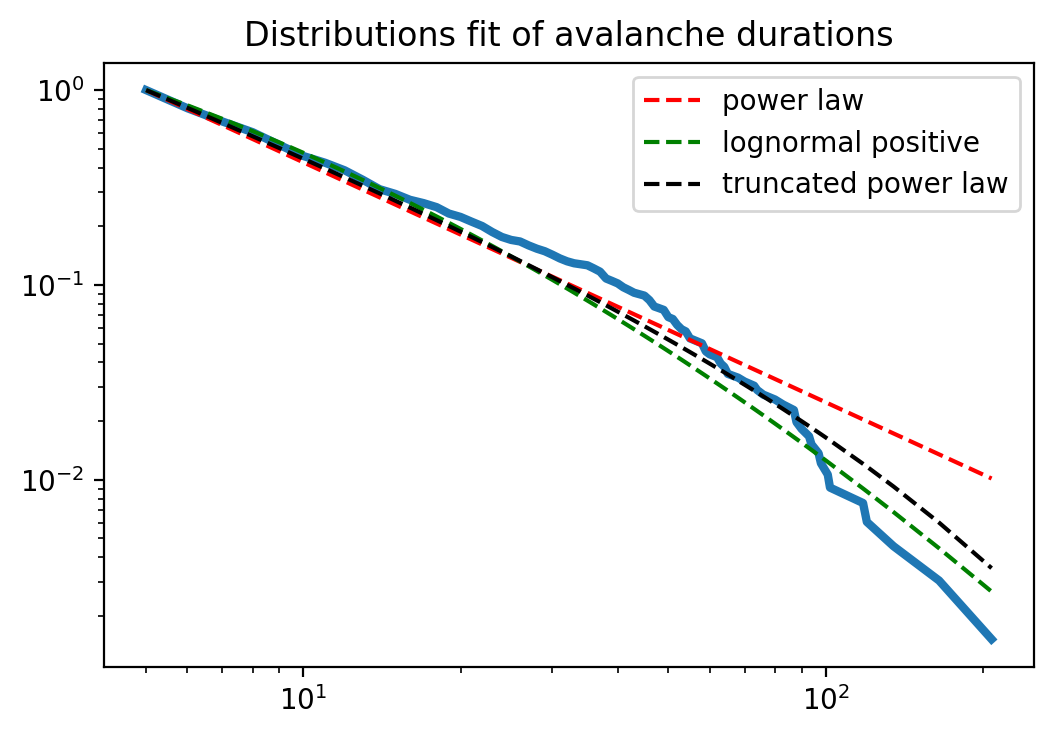

In [214]:
for distribution in ['lognormal_positive', 
                     'lognormal', 'truncated_power_law']:
    R, p = steady_durations.distribution_compare('power_law', distribution)
    print(distribution, R, p)
    
plt.subplots(dpi=200)
fig4=steady_durations.plot_ccdf(linewidth=3)
steady_durations.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--', label = 'power law')
steady_durations.lognormal_positive.plot_ccdf(ax=fig4, color='g', linestyle='--', label = 'lognormal positive')
steady_durations.truncated_power_law.plot_ccdf(ax=fig4, color='k', linestyle='--', label = 'truncated power law')
plt.legend()
plt.title('Distributions fit of avalanche durations');

lognormal_positive 45.88405902163507 1.080619617183996e-09
lognormal 0.022726592148651026 0.19233154803597963


Assuming nested distributions


truncated_power_law -3.480290558198477 0.008332496522820976


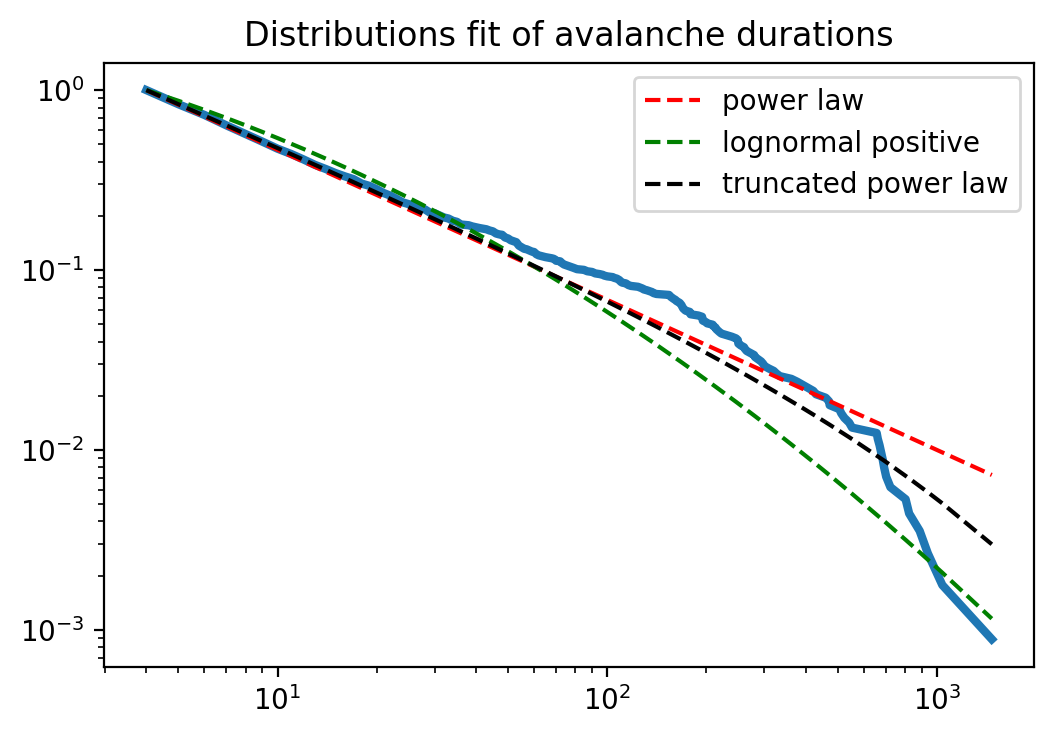

In [215]:
for distribution in ['lognormal_positive', 
                     'lognormal', 'truncated_power_law']:
    R, p = steady_sizes.distribution_compare('power_law', distribution)
    print(distribution, R, p)
    
plt.subplots(dpi=200)
fig4=steady_sizes.plot_ccdf(linewidth=3)
steady_sizes.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--', label = 'power law')
steady_sizes.lognormal_positive.plot_ccdf(ax=fig4, color='g', linestyle='--', label = 'lognormal positive')
steady_sizes.truncated_power_law.plot_ccdf(ax=fig4, color='k', linestyle='--', label = 'truncated power law')
plt.legend()
plt.title('Distributions fit of avalanche durations');

# Calculate criticality coefficients

## Power spectra

In [ ]:
from scipy import fft
from scipy import signal

In [ ]:
spectrum = np.vstack([np.abs(np.fft.rfft(sp)) for sp in np.split(spike_sum, 20)]).mean(axis=0)

In [ ]:
plt.plot(np.abs(spectrum))
plt.xlim(0, 100)
plt.ylim(0, 1500)

In [ ]:
plt.plot(np.abs(spectrum))
plt.xlim(1, 120)
plt.ylim(100, 2000)
plt.yscale('log')
plt.xscale('log')

## Power law

In [ ]:
len(avalanche_sizes)

In [ ]:
q = np.linspace(0,1,1000)
tail_cdf = -1*np.quantile(-np.array(avalanche_sizes), q)

In [ ]:
plt.subplots(dpi=200)
plt.plot(tail_cdf[q > .01], q[q > .01])
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.subplots(dpi=200)
density, bin = np.histogram(np.log10(avalanche_durations), density=True, bins=10)
durations = (10**bin[:-1])

C = density[0]/durations[0]

plt.plot(durations, density, marker='o', label='actuals')
plt.plot(durations, C*durations**(-1.4), label='1.4')
plt.plot(durations, C*durations**(-1.2), label='1.2')
plt.plot(durations, C*durations**(-.9), label='0.9')
plt.legend()
plt.yscale('log')
plt.xscale('log')

# Visuals

In [ ]:
spike_history = (np.random.rand(500,2000) > .995).astype(int) # Random "s"
rasterplot(spike_history, 1, s=.1)
sns.despine(left=True)